In [22]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
from PIL import ImageFilter
from PIL import Image
from numpy import asarray
from sklearn.model_selection import train_test_split

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "train", "images", "*.jpg")))
    train_y = sorted(glob(os.path.join(path, "train", "masks", "*.jpg")))
    
    test_x = sorted(glob(os.path.join(path, "test", "images", "*.jpg")))
    test_y = sorted(glob(os.path.join(path, "test", "masks", "*.jpg")))
    
    return (train_x, train_y), (test_x, test_y)


def augment_data(images, masks, save_path, augment= True):
    size = (448, 448)
    
    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total = len(images)):
        name = x.split("/")[-1].split("\\")[-1].split(".")[0]
        
        x_na = Image.open(x)
        y_na = Image.open(y)
        
        
        if augment == True:
            moreEdgeEnahnced_x = x_na.filter(ImageFilter.EDGE_ENHANCE)
            moreEdgeEnahnced_y = y_na.filter(ImageFilter.EDGE_ENHANCE)
            x = asarray(moreEdgeEnahnced_x)
            y = asarray(moreEdgeEnahnced_y)
            X = [x]
            Y = [y]
        else:
            x = asarray(x_na)
            y = asarray(y_na)
            X = [x]
            Y = [y]
            
        index = 0
        for i,m in zip(X,Y):
            i = cv2.resize(i,size)
            m = cv2.resize(m, size)
            
            temp_image_name = f"{name}_{index}.jpg"
            temp_mask_name = f"{name}_{index}.jpg"
            
            image_path = os.path.join(save_path, "image", temp_image_name)
            mask_path = os.path.join(save_path, "mask", temp_mask_name)
            
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)
            
            index += 1
            
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    
    """ Load the data """
    data_path = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset"
    (train_x, train_y), (test_x, test_y) = load_data(data_path)
    
    
    
    (X_train, X_valid, y_train, y_valid) = train_test_split(train_x, train_y,
                                                        test_size=0.2,
                                                        random_state=42)

    
    print(f"Train: {len(X_train)} - {len(y_train)}")
    print(f"Valid: {len(X_valid)} - {len(y_valid)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")
    
    create_dir("new_data3/train/image/")
    create_dir("new_data3/train/mask/")
    create_dir("new_data3/valid/image/")
    create_dir("new_data3/valid/mask/")
    create_dir("new_data3/test/image/")
    create_dir("new_data3/test/mask/")
    
    augment_data(X_train, y_train, "new_data3/train", augment=True)
    augment_data(test_x, test_y, "new_data3/test", augment=True)
    augment_data(X_valid, y_valid, "new_data3/valid", augment=True)

Train: 7682 - 7682
Valid: 1921 - 1921
Test: 1695 - 1695


100%|██████████| 1921/1921 [00:40<00:00, 47.76it/s]


In [23]:
import matplotlib.pyplot as plt
path = "/kaggle/working/new_data3/test/image/"

i = 0
listimage= []
for img in os.listdir(path):
    picture = cv2.imread(os.path.join(path,img))
    print(picture)
    i = i+1
    break

[[[ 95  95  95]
  [ 98  98  98]
  [ 95  95  95]
  ...
  [104 104 104]
  [100 100 100]
  [102 102 102]]

 [[ 95  95  95]
  [ 96  96  96]
  [ 95  95  95]
  ...
  [105 105 105]
  [ 97  97  97]
  [ 97  97  97]]

 [[ 94  94  94]
  [ 93  93  93]
  [ 96  96  96]
  ...
  [101 101 101]
  [ 86  86  86]
  [ 94  94  94]]

 ...

 [[124 122 121]
  [126 124 123]
  [133 131 130]
  ...
  [106 106 106]
  [ 98  98  98]
  [104 104 104]]

 [[122 120 119]
  [131 129 128]
  [131 129 128]
  ...
  [101 101 101]
  [ 90  90  90]
  [105 105 105]]

 [[123 121 120]
  [120 118 117]
  [120 118 117]
  ...
  [103 103 103]
  [ 94  94  94]
  [103 103 103]]]


In [31]:
print(len(listimage))

0


In [24]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self,in_c,out_c):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding =1)
        self.bn1 = nn.BatchNorm2d(out_c)
        
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding =1)
        self.bn2 = nn.BatchNorm2d(out_c)
        
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x= self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x= self.relu(x)
        
        return x
        
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2,2))
        
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding = 0)
        self.conv = conv_block(out_c+out_c, out_c)
    
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x,skip], axis=1)
        x = self.conv(x)
        return x
        
        
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.e1 = encoder_block(3,64)
        self.e2 = encoder_block(64,128)
        self.e3 = encoder_block(128,256)
        self.e4 = encoder_block(256,512)
        
        self.b = conv_block(512,1024)
        
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        
        self.outputs = nn.Conv2d(64,1,kernel_size=1, padding=0)
        
    def forward(self, inputs):
        
        s1,p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        
        b = self.b(p4)
        
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        
        outputs = self.outputs(d4)
        
        return outputs
        
if __name__ == "__main__":
    x = torch.randn((2,3,512,512))
    f = build_unet()
    y = f(x)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE 

In [26]:
import os
import time
import random
import numpy as np
import cv2
import torch

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
import os
import numpy as np
import cv2
import torch
from PIL import Image
from torch.utils.data import Dataset
from numpy import asarray

class DriveDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform = None):

        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.n_samples = len(image_dir)
        self.transform = transform
        self.images = os.listdir(image_dir)


    def __getitem__(self, index):
        """ Reading image """
        img_path = os.path.join(self.image_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32)
        image = image/255.0
        image = np.transpose(image, (2, 0, 1))
        """ Reading mask """
        mask_path = os.path.join(self.mask_dir, self.images[index])
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask = mask/255.0
        mask = np.expand_dims(mask, axis=0)
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            
        return image, mask

    def __len__(self):
        return self.n_samples

In [28]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [29]:
import os
import time
from glob import glob
from tqdm import trange, tqdm
from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

def train(model, loader, optimizer, loss_fn, epoch, device):
    loop = tqdm(loader)
    metric_monitor = MetricMonitor()
    epoch_loss = 0.0

    model.train()
    for batch_idx, (x, y) in enumerate(loop, start=1):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x).squeeze(1)
        loss = loss_fn(y_pred, y)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())
        loop.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader,optimizer, loss_fn, epoch, device):
    metric_monitor = MetricMonitor()
    epoch_loss = 0.0

    model.eval()
    stream = tqdm(loader)
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(stream, start=1):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x).squeeze(1)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss



def augmentationsTrain():
    return A.Compose([
        A.Rotate(limit=45, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
        A.ElasticTransform(alpha=100, sigma=10, p=0.5)
    ])


def augmentationsVal():
    return A.Compose([
        A.Rotate(limit=45, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    ])


if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("files")
    
    train_x = "/kaggle/working/new_data3/train/image/"
    train_y = "/kaggle/working/new_data3/train/mask/"
    
    valid_x = "/kaggle/working/new_data3/valid/image/"
    valid_y = "/kaggle/working/new_data3/valid/mask/"
    
    train_xx = sorted(glob("/kaggle/working/new_data3/train/image/*"))
    valid_xx =sorted(glob("/kaggle/working/new_data3/valid/image/*"))
    
    data_str = f"Dataset Size:\nTrain: {len(train_xx)} - Valid: {len(valid_xx)}\n"
    print(data_str)
    
    H = 448
    W = 448
    size = (H,W)
    batch_size = 4
    num_epochs = 120
    lr = 0.0001
    checkpoint_path = "files/checkpoint.pth"
    
    train_transform = augmentationsTrain()
    
    train_dataset = DriveDataset(train_x, train_y)
    
    val_transform = augmentationsVal()
    
    valid_dataset = DriveDataset(valid_x, valid_y)
    
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )
    
    device = torch.device('cuda')   ## GTX 1060 6GB
    model = build_unet()
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()
    

    best_valid_loss = float("inf")
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train(model, train_loader, optimizer, loss_fn, epoch, device)
        valid_loss = evaluate(model, valid_loader,optimizer, loss_fn, epoch, device)
        
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)
        
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

Dataset Size:
Train: 7682 - Valid: 1921



Epoch: 0. Validation. Loss: 1.515: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Valid loss improved from inf to 1.5146. Saving checkpoint: files/checkpoint.pth


Epoch: 1. Validation. Loss: 1.457: 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


Valid loss improved from 1.5146 to 1.4568. Saving checkpoint: files/checkpoint.pth


Epoch: 2. Validation. Loss: 1.378: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Valid loss improved from 1.4568 to 1.3783. Saving checkpoint: files/checkpoint.pth


Epoch: 5. Validation. Loss: 1.277: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Valid loss improved from 1.3783 to 1.2768. Saving checkpoint: files/checkpoint.pth


Epoch: 7. Validation. Loss: 1.270: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Valid loss improved from 1.2768 to 1.2699. Saving checkpoint: files/checkpoint.pth


Epoch: 8. Validation. Loss: 1.234: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Valid loss improved from 1.2699 to 1.2343. Saving checkpoint: files/checkpoint.pth


Epoch: 9. Validation. Loss: 1.217: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Valid loss improved from 1.2343 to 1.2175. Saving checkpoint: files/checkpoint.pth


Epoch: 10. Validation. Loss: 1.191: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Valid loss improved from 1.2175 to 1.1910. Saving checkpoint: files/checkpoint.pth


Epoch: 12. Validation. Loss: 1.178: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Valid loss improved from 1.1910 to 1.1785. Saving checkpoint: files/checkpoint.pth


Epoch: 13. Validation. Loss: 1.117: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Valid loss improved from 1.1785 to 1.1173. Saving checkpoint: files/checkpoint.pth


Epoch: 17. Validation. Loss: 1.111: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Valid loss improved from 1.1173 to 1.1107. Saving checkpoint: files/checkpoint.pth


Epoch: 20. Validation. Loss: 1.111: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Valid loss improved from 1.1107 to 1.1106. Saving checkpoint: files/checkpoint.pth


Epoch: 22. Validation. Loss: 1.094: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Valid loss improved from 1.1106 to 1.0937. Saving checkpoint: files/checkpoint.pth


Epoch: 23. Validation. Loss: 1.093: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Valid loss improved from 1.0937 to 1.0931. Saving checkpoint: files/checkpoint.pth


Epoch: 24. Validation. Loss: 1.067: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Valid loss improved from 1.0931 to 1.0674. Saving checkpoint: files/checkpoint.pth


Epoch: 26. Validation. Loss: 1.066: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Valid loss improved from 1.0674 to 1.0660. Saving checkpoint: files/checkpoint.pth


Epoch: 27. Validation. Loss: 1.047: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Valid loss improved from 1.0660 to 1.0472. Saving checkpoint: files/checkpoint.pth


Epoch: 30. Validation. Loss: 1.021: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Valid loss improved from 1.0472 to 1.0207. Saving checkpoint: files/checkpoint.pth


Epoch: 32. Validation. Loss: 1.004: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Valid loss improved from 1.0207 to 1.0036. Saving checkpoint: files/checkpoint.pth


Epoch: 36. Validation. Loss: 1.002: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Valid loss improved from 1.0036 to 1.0020. Saving checkpoint: files/checkpoint.pth


Epoch: 40. Validation. Loss: 0.999: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Valid loss improved from 1.0020 to 0.9990. Saving checkpoint: files/checkpoint.pth


Epoch: 42. Validation. Loss: 0.974: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Valid loss improved from 0.9990 to 0.9745. Saving checkpoint: files/checkpoint.pth


Epoch: 45. Validation. Loss: 0.952: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Valid loss improved from 0.9745 to 0.9519. Saving checkpoint: files/checkpoint.pth


Epoch: 47. Validation. Loss: 0.931: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Valid loss improved from 0.9519 to 0.9312. Saving checkpoint: files/checkpoint.pth


Epoch: 53. Validation. Loss: 0.905: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Valid loss improved from 0.9312 to 0.9050. Saving checkpoint: files/checkpoint.pth


Epoch: 59. Validation. Loss: 0.881: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Valid loss improved from 0.9050 to 0.8812. Saving checkpoint: files/checkpoint.pth


Epoch: 65. Validation. Loss: 0.873: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Valid loss improved from 0.8812 to 0.8726. Saving checkpoint: files/checkpoint.pth


Epoch: 70. Validation. Loss: 0.865: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Valid loss improved from 0.8726 to 0.8651. Saving checkpoint: files/checkpoint.pth


Epoch: 82. Validation. Loss: 0.860: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Valid loss improved from 0.8651 to 0.8600. Saving checkpoint: files/checkpoint.pth


Epoch: 85. Validation. Loss: 0.856: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


Valid loss improved from 0.8600 to 0.8557. Saving checkpoint: files/checkpoint.pth


Epoch: 86. Validation. Loss: 0.846: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Valid loss improved from 0.8557 to 0.8456. Saving checkpoint: files/checkpoint.pth


Epoch: 93. Validation. Loss: 0.818: 100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Valid loss improved from 0.8456 to 0.8182. Saving checkpoint: files/checkpoint.pth


Epoch: 94. Validation. Loss: 0.797: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Valid loss improved from 0.8182 to 0.7974. Saving checkpoint: files/checkpoint.pth


Epoch: 110. Validation. Loss: 0.786: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Valid loss improved from 0.7974 to 0.7864. Saving checkpoint: files/checkpoint.pth


Epoch: 115. Validation. Loss: 0.776: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Valid loss improved from 0.7864 to 0.7763. Saving checkpoint: files/checkpoint.pth


Epoch: 117. Validation. Loss: 0.737: 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


Valid loss improved from 0.7763 to 0.7365. Saving checkpoint: files/checkpoint.pth


Epoch: 119. Validation. Loss: 0.924: 100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


In [30]:
import os, time
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred, zero_division=0)
    score_f1 = f1_score(y_true, y_pred, zero_division=0)
    score_recall = recall_score(y_true, y_pred, zero_division=0)
    score_precision = precision_score(y_true, y_pred,zero_division=0)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]


def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask


if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Folders """
    create_dir("results")

    """ Load dataset """
    test_x = sorted(glob("/kaggle/working/new_data3/test/image/*"))
    test_y = sorted(glob("/kaggle/working/new_data3/test/mask/*"))
    
    
    
    H = 448
    W = 448
    size = (W, H)
    checkpoint_path = "files/checkpoint.pth"
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    
    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []
    
    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0] 
        
        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
        ## image = cv2.resize(image, size)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)
        
        """ Reading mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        ## mask = cv2.resize(mask, size)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)
        
        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y)
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)
            
        """ Saving masks """
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128

        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        cv2.imwrite(f"results/{name}.png", cat_images)
        
    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")
    
    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)

100%|██████████| 1695/1695 [07:26<00:00,  3.80it/s]

Jaccard: 0.2722 - F1: 0.3770 - Recall: 0.3794 - Precision: 0.4921 - Acc: 0.9676
FPS:  179.51464163835453


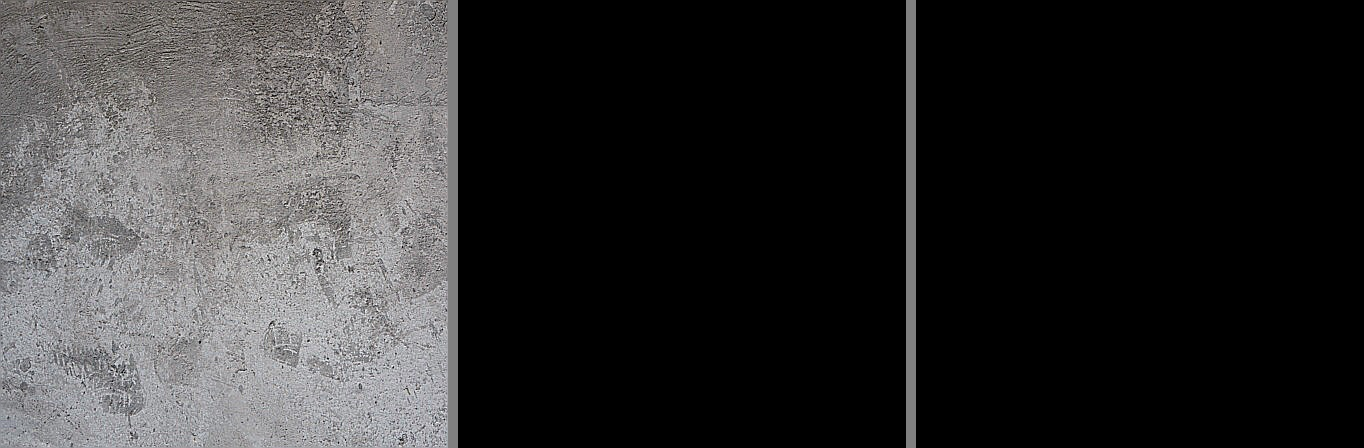

In [38]:
from IPython.display import display
from PIL import Image


path="/kaggle/working/results/noncrack_noncrack_concrete_wall_54_36_0.png"
display(Image.open(path))

In [9]:
import matplotlib.pyplot as plt
i = 0
path = "/kaggle/working/results"
for img in os.listdir(path):
    print(img)


Rissbilder_for_Florian_9S6A2874_251_526_2458_2696_0.png
CFD_047_0.png
noncrack_noncrack_concrete_wall_55_32_0.png
Rissbilder_for_Florian_9S6A3134_76_855_3718_4555_0.png
CRACK500_20160324_165857_1281_361_0.png
CRACK500_20160330_170302_1_721_0.png
CRACK500_20160308_072921_1281_361_0.png
Rissbilder_for_Florian_9S6A3088_370_2375_2620_2464_0.png
Sylvie_Chambon_022_0.png
CRACK500_20160328_153524_641_361_0.png
CRACK500_20160328_151657_641_721_0.png
CRACK500_20160326_142403_1921_361_0.png
CRACK500_20160222_114759_1921_721_0.png
CRACK500_20160328_153421_641_1_0.png
DeepCrack_IMG_6472-1_0.png
GAPS384_train_1028_1_1_0.png
CRACK500_20160328_152322_1281_721_0.png
CRACK500_20160329_104120_1_361_0.png
Rissbilder_for_Florian_9S6A3127_595_2880_2296_2633_0.png
cracktree200_6329_0.png
CRACK500_20160330_163725_1921_361_0.png
DeepCrack_11271-5_0.png
Volker_DSC01698_213_356_1899_1462_0.png
Rissbilder_for_Florian_9S6A2875_36_523_3631_3027_0.png
Rissbilder_for_Florian_9S6A2864_474_1863_3308_2536_0.png
CRACK50